# Create SICBL-LAD lookup

Sometimes the Sub-Integrated Care Board Locations (SICBLs) cover too large areas for our purposes, and it is more convenient to use Local Authority Districts (LADs) instead.

An example of this is that the SICBL named "NHS Hampshire and Isle Of Wight ICB - D9Y0V" contains both parts of Hampshire on mainland UK and the Isle of Wight. When considering geographic modelling, usually the Isle of Wight is a special case when travel to the mainland is considered, and it has its own ambulance service. This means it is beneficial to be able to split the Isle of Wight from Hampshire.

In this notebook we compare the boundaries of SICBLs in July 2022 and LADs in December 2022. We then create a lookup file from SICBL to LAD with names and codes.

## Notebook setup

In [1]:
# For handling the tabular data:
import pandas as pd
# For maps:
import geopandas
import matplotlib.pyplot as plt

# For tracking paths to files:
import os
from dataclasses import dataclass

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    # Directories:
    dir_ons_tabular = '../data_tabular/ons_data/'
    dir_tabular = '../data_tabular/'
    dir_ons_geojson = '../data_geojson/ons_data/'
    dir_output = 'output_data'
    dir_output_images = 'output_images'

    # Tabular data:
    sicbl_icb = 'LOC22_ICB22_NHSER22_EN_LU.csv'
    lad_country = 'Local_Authority_District_to_Country_(December_2022)_Lookup_in_the_United_Kingdom.csv'
    sicbl_lad = 'LSOA11_LOC22_ICB22_LAD22_EN_LU.csv'
    ccg_ambo = 'ambulance_service_info_ccg_lookup.csv'
    ccg_sicbl = 'ccg_stp_sicbl_icb.csv'

    # Boundaries data:
    sicbl_geojson = 'SICBL_JUL_2022_EN_BUC.geojson'
    lad_geojson = 'Local_Authority_Districts_December_2022_UK_BUC_V2.geojson'

    # Output:
    df_output = 'sicbl_lad.csv'
    image_sicbl_lad = 'boundaries_sicbl22_lad22.png'
    image_sicbl_lad_ambo = 'boundaries_sicbl22_lad22_ambo.png'

paths = Paths()

## Import region files

In [3]:
gdf_sicbl = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.sicbl_geojson))
gdf_lad = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.lad_geojson))

Limit LAD to England:

In [4]:
df_lad_country = pd.read_csv(os.path.join(paths.dir_ons_tabular, paths.lad_country))

df_lad_country.head(3)

,LAD22CD,LAD22NM,CTRY22CD,CTRY22NM,ObjectId
0,E06000001,Hartlepool,E92000001,England,1
1,E06000002,Middlesbrough,E92000001,England,2
2,E06000003,Redcar and Cleveland,E92000001,England,3


In [5]:
lads_to_keep = df_lad_country[df_lad_country['CTRY22NM'] == 'England']['LAD22CD']

In [6]:
gdf_lad = gdf_lad[gdf_lad['LAD22CD'].isin(lads_to_keep)].copy()

## Link Ambo to SICBL and LAD

In [7]:
df_ccg_ambo = pd.read_csv(os.path.join(paths.dir_tabular, paths.ccg_ambo))

df_ccg_ambo.head(3)

,NHS CCG code,CCG name,Office for National Statistics (ONS) April 2021 CCG code,Ambulance Service,NHS Ambulance Service Region Name,NHS Ambulance Service Region code,ONS Ambulance Service Region Code
0,02Q,NHS Bassetlaw CCG,E38000008,EMAS,Midlands,Y60,E40000008
1,03W,NHS East Leicestershire and Rutland CCG,E38000051,EMAS,Midlands,Y60,E40000008
2,04C,NHS Leicester City CCG,E38000097,EMAS,Midlands,Y60,E40000008


In [8]:
df_ccg_sicbl = pd.read_csv(os.path.join(paths.dir_output, paths.ccg_sicbl))

df_ccg_sicbl.head(3)

,CCG21CD,CCG21CDH,CCG21NM,STP21CD,STP21CDH,STP21NM,LOC22CD,LOC22CDH,LOC22NM,ICB22CD,ICB22CDH,ICB22NM,boundaries_changed_ccg_loc,boundaries_changed_stp_icb
0,E38000068,01F,NHS Halton CCG,E54000008,QYG,Cheshire and Merseyside,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,False,False
1,E38000091,01J,NHS Knowsley CCG,E54000008,QYG,Cheshire and Merseyside,E38000091,01J,NHS Cheshire and Merseyside ICB - 01J,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,False,False
2,E38000101,99A,NHS Liverpool CCG,E54000008,QYG,Cheshire and Merseyside,E38000101,99A,NHS Cheshire and Merseyside ICB - 99A,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,False,False


In [9]:
df_sicbl_ambo = pd.merge(df_ccg_ambo, df_ccg_sicbl, left_on='NHS CCG code', right_on='CCG21CDH', how='right')

df_sicbl_ambo.head(3).T

,0,1,2
NHS CCG code,01F,01J,99A
CCG name,NHS Halton CCG,NHS Knowsley CCG,NHS Liverpool CCG
Office for National Statistics (ONS) April 2021 CCG code,E38000068,E38000091,E38000101
Ambulance Service,NWAS,NWAS,NWAS
NHS Ambulance Service Region Name,North West,North West,North West
NHS Ambulance Service Region code,Y62,Y62,Y62
ONS Ambulance Service Region Code,E40000010,E40000010,E40000010
CCG21CD,E38000068,E38000091,E38000101
CCG21CDH,01F,01J,99A
CCG21NM,NHS Halton CCG,NHS Knowsley CCG,NHS Liverpool CCG


## Check whether LAD and SICBL line up exactly.

Use the lookup file from the ONS to see whether any LAD lie in multiple SICBL.

In [10]:
df_lsoa_lad_sicbl = pd.read_csv(os.path.join(paths.dir_ons_tabular, paths.sicbl_lad))

df_lsoa_lad_sicbl.head(3)

,LSOA11CD,LSOA11NM,LOC22CD,LOC22CDH,LOC22NM,ICB22CD,ICB22CDH,ICB22NM,LAD22CD,LAD22NM
0,E01012367,Halton 007A,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton
1,E01012368,Halton 003A,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton
2,E01012369,Halton 005A,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton


Remove the LSOA columns and drop duplicate rows:

In [11]:
df_lad_sicbl = df_lsoa_lad_sicbl.drop(['LSOA11CD', 'LSOA11NM'], axis='columns').drop_duplicates()

In [12]:
df_lad_sicbl.head(3)

,LOC22CD,LOC22CDH,LOC22NM,ICB22CD,ICB22CDH,ICB22NM,LAD22CD,LAD22NM
0,E38000068,01F,NHS Cheshire and Merseyside ICB - 01F,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000006,Halton
79,E38000194,02E,NHS Cheshire and Merseyside ICB - 02E,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000007,Warrington
206,E38000233,27D,NHS Cheshire and Merseyside ICB - 27D,E54000008,QYG,NHS Cheshire and Merseyside Integrated Care Board,E06000049,Cheshire East


For each LAD, check which SICBL (labelled LOC) contain it:

In [13]:
lads_to_keep = sorted(list(set(df_lad_sicbl['LAD22NM'])))

In [14]:
lad_sicbl_count_dict = {}

for lad in lads_to_keep:
    df_here = df_lad_sicbl.loc[df_lad_sicbl['LAD22NM'] == lad]
    lad_sicbl_count_dict[lad] = len(df_here)

In [15]:
lad_sicbl_count = pd.Series(lad_sicbl_count_dict)

lad_sicbl_count_multi = lad_sicbl_count[lad_sicbl_count != 1]

lad_sicbl_count_multi

Babergh                     2
Blaby                       2
Buckinghamshire             2
Charnwood                   2
Chichester                  2
Copeland                    2
Craven                      2
East Riding of Yorkshire    2
East Suffolk                2
Guildford                   2
Hambleton                   2
Harborough                  2
Hart                        2
Lichfield                   3
Mid Suffolk                 2
North Hertfordshire         2
Preston                     2
Ribble Valley               2
Runnymede                   2
Ryedale                     2
Sefton                      2
South Oxfordshire           2
South Ribble                2
South Staffordshire         3
Staffordshire Moorlands     2
Surrey Heath                2
Vale of White Horse         2
Waverley                    2
West Suffolk                2
dtype: int64

Pick these LAD out of the geodataframe and stick them in their own one:

In [16]:
gdf_lad_to_fill = gdf_lad[gdf_lad['LAD22NM'].isin(lad_sicbl_count_multi.index)]

In [17]:
len(lad_sicbl_count_multi), len(gdf_lad_to_fill)

(29, 29)

Link LOC to Ambulance service:

In [18]:
df_lad_sicbl_ambo = pd.merge(
    df_lad_sicbl,
    df_sicbl_ambo[['LOC22CD', 'Ambulance Service ', 'NHS Ambulance Service Region Name']],
    on='LOC22CD', how='left'
)

Some of these have missing ambulance service data:

In [19]:
df_lad_sicbl_ambo[df_lad_sicbl_ambo.isna().any(axis='columns')]

,LOC22CD,LOC22CDH,LOC22NM,ICB22CD,ICB22CDH,ICB22NM,LAD22CD,LAD22NM,Ambulance Service,NHS Ambulance Service Region Name
76,E38000249,M1J4Y,"NHS Bedfordshire, Luton and Milton Keynes ICB ...",E54000024,QHG,"NHS Bedfordshire, Luton and Milton Keynes Inte...",E06000032,Luton,NaN,NaN
77,E38000249,M1J4Y,"NHS Bedfordshire, Luton and Milton Keynes ICB ...",E54000024,QHG,"NHS Bedfordshire, Luton and Milton Keynes Inte...",E06000042,Milton Keynes,NaN,NaN
78,E38000249,M1J4Y,"NHS Bedfordshire, Luton and Milton Keynes ICB ...",E54000024,QHG,"NHS Bedfordshire, Luton and Milton Keynes Inte...",E06000055,Bedford,NaN,NaN
79,E38000249,M1J4Y,"NHS Bedfordshire, Luton and Milton Keynes ICB ...",E54000024,QHG,"NHS Bedfordshire, Luton and Milton Keynes Inte...",E06000056,Central Bedfordshire,NaN,NaN
80,E38000249,M1J4Y,"NHS Bedfordshire, Luton and Milton Keynes ICB ...",E54000024,QHG,"NHS Bedfordshire, Luton and Milton Keynes Inte...",E06000060,Buckinghamshire,NaN,NaN
184,E38000253,D9Y0V,NHS Hampshire and Isle of Wight ICB - D9Y0V,E54000042,QRL,NHS Hampshire and Isle of Wight Integrated Car...,E06000045,Southampton,NaN,NaN
185,E38000253,D9Y0V,NHS Hampshire and Isle of Wight ICB - D9Y0V,E54000042,QRL,NHS Hampshire and Isle of Wight Integrated Car...,E06000046,Isle of Wight,NaN,NaN
186,E38000253,D9Y0V,NHS Hampshire and Isle of Wight ICB - D9Y0V,E54000042,QRL,NHS Hampshire and Isle of Wight Integrated Car...,E07000084,Basingstoke and Deane,NaN,NaN
187,E38000253,D9Y0V,NHS Hampshire and Isle of Wight ICB - D9Y0V,E54000042,QRL,NHS Hampshire and Isle of Wight Integrated Car...,E07000085,East Hampshire,NaN,NaN
188,E38000253,D9Y0V,NHS Hampshire and Isle of Wight ICB - D9Y0V,E54000042,QRL,NHS Hampshire and Isle of Wight Integrated Car...,E07000086,Eastleigh,NaN,NaN


For each LAD, check which ambulance services cover it:

In [20]:
df_lad_ambo = df_lad_sicbl_ambo.drop(['LOC22NM', 'LOC22CD', 'LOC22CDH', 'ICB22CD', 'ICB22CDH', 'ICB22NM'], axis='columns').drop_duplicates()

In [21]:
lads_to_keep = sorted(list(set(df_lad_sicbl['LAD22NM'])))

In [22]:
lad_ambo_count_dict = {}

for lad in lads_to_keep:
    df_here = df_lad_ambo.loc[df_lad_ambo['LAD22NM'] == lad]
    lad_ambo_count_dict[lad] = len(df_here)

In [23]:
lad_ambo_count = pd.Series(lad_ambo_count_dict)

lad_ambo_count_multi = lad_ambo_count[lad_ambo_count != 1]

lad_ambo_count_multi

Buckinghamshire        2
Craven                 2
Hart                   2
Vale of White Horse    2
dtype: int64

Pick these LAD out of the geodataframe and stick them in their own one:

In [24]:
gdf_lad_to_fill_ambo = gdf_lad[gdf_lad['LAD22NM'].isin(lad_ambo_count_multi.index)]

In [25]:
len(lad_ambo_count_multi), len(gdf_lad_to_fill_ambo)

(4, 4)

## Define function for making maps

In [26]:
def make_maps(gdf0, gdf1, gdf_to_fill=None, titles=[], savename=''):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the region boundaries:
    # n.b. labels added here won't appear in the legend.
    if gdf_to_fill is None:
        pass
    else:
        gdf_to_fill.plot(ax=ax, facecolor='salmon', edgecolor='None')
    gdf0.plot(ax=ax, facecolor='none', edgecolor='r')
    gdf1.plot(ax=ax, facecolor='none', edgecolor='k')

    # Remove the frame, axis ticks, labels...
    ax.axis('off')

    # Fake a legend:
    x, _, _, _ = gdf0['geometry'].total_bounds
    ax.plot([x, x+1e-7], [x, x+1e-7], color='r', label=titles[0])
    ax.plot([x, x+1e-7], [x, x+1e-7], color='k', label=titles[1])
    if len(titles) > 2:
        ax.fill([x, x+1e-7], [x, x+1e-7], color='salmon', label=titles[2])
    ax.legend()

    if len(savename) > 0:
        plt.savefig(savename, bbox_inches='tight')

    plt.show()

In [35]:
def make_maps_2ax(gdf0, gdf1, gdf_to_fill=None, titles=[], savename=''):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    ax = axs[0]
    ax1 = axs[1]
    
    # Draw the region boundaries:
    # n.b. labels added here won't appear in the legend.
    if gdf_to_fill is None:
        pass
    else:
        gdf_to_fill.plot(ax=ax, facecolor='salmon', edgecolor='None')
    gdf0.plot(ax=ax, facecolor='none', edgecolor='r')
    gdf1.plot(ax=ax1, facecolor='none', edgecolor='k')

    # Remove the frame, axis ticks, labels...
    ax.axis('off')
    ax1.axis('off')

    # Fake a legend:
    x, _, _, _ = gdf0['geometry'].total_bounds
    ax.plot([x, x+1e-7], [x, x+1e-7], color='r', label=titles[0])
    ax1.plot([x, x+1e-7], [x, x+1e-7], color='k', label=titles[1])
    if len(titles) > 2:
        ax.fill([x, x+1e-7], [x, x+1e-7], color='salmon', label=titles[2])
    ax.legend()
    ax1.legend()

    if len(savename) > 0:
        plt.savefig(savename, bbox_inches='tight')

    plt.show()

## Compare CCG with SICBL

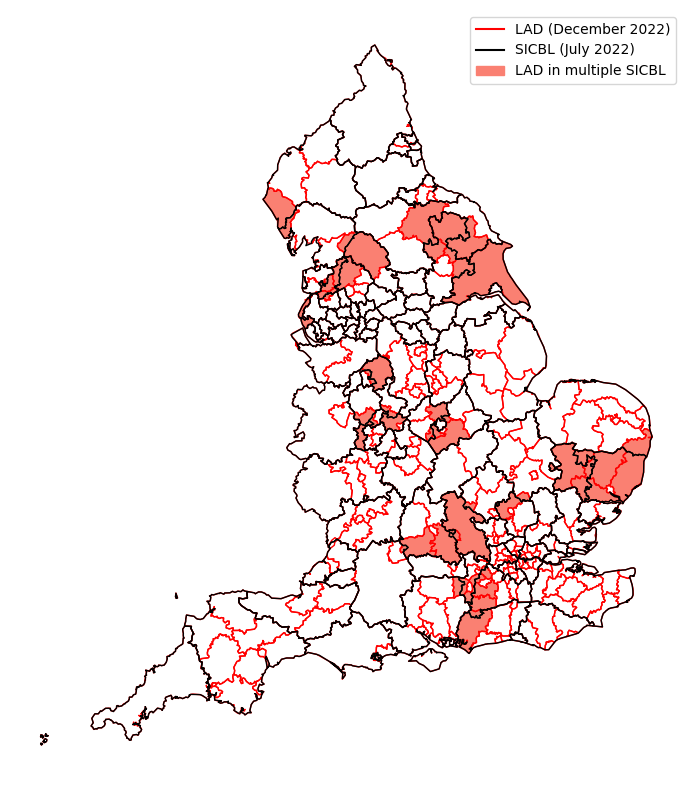

In [27]:
make_maps(
    gdf_lad, gdf_sicbl, gdf_lad_to_fill,
    titles=['LAD (December 2022)', 'SICBL (July 2022)', 'LAD in multiple SICBL'],
    savename=os.path.join(paths.dir_output_images, paths.image_sicbl_lad)
)

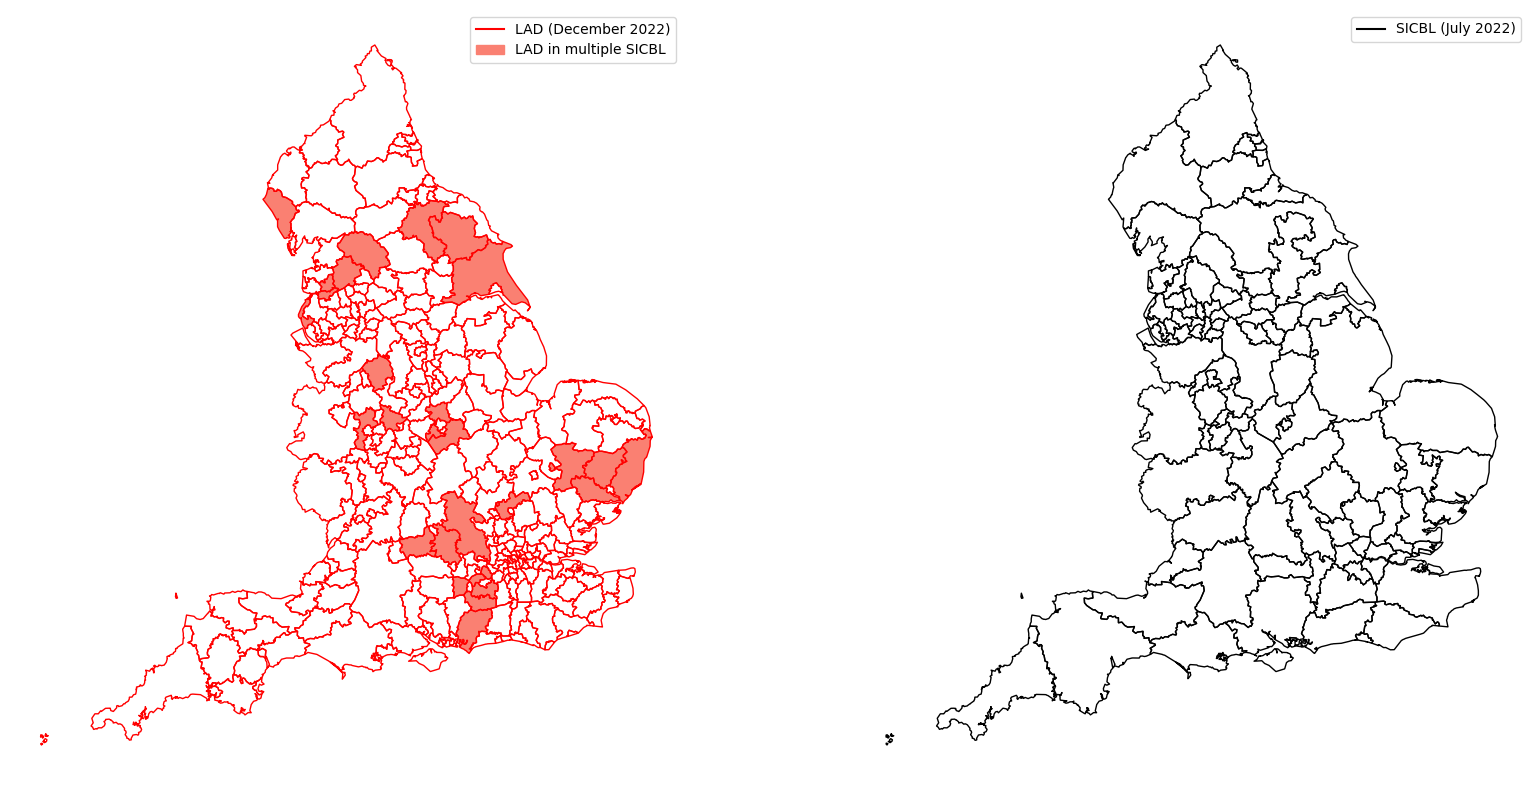

In [36]:
make_maps_2ax(
    gdf_lad, gdf_sicbl, gdf_lad_to_fill,
    titles=['LAD (December 2022)', 'SICBL (July 2022)', 'LAD in multiple SICBL'],
    savename=os.path.join(paths.dir_output_images, paths.image_sicbl_lad + '2ax.png')
)

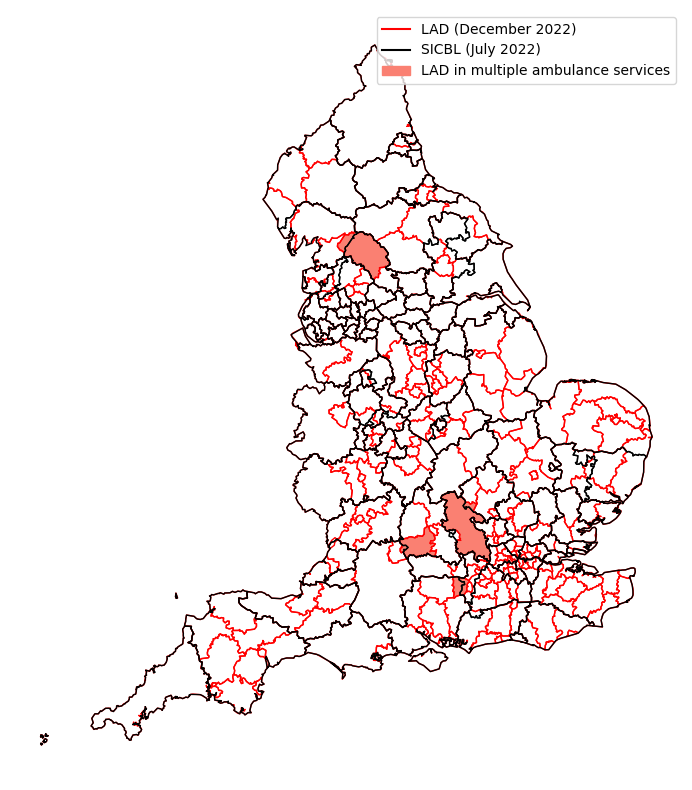

In [28]:
make_maps(
    gdf_lad, gdf_sicbl, gdf_lad_to_fill_ambo,
    titles=['LAD (December 2022)', 'SICBL (July 2022)', 'LAD in multiple ambulance services'],
    savename=os.path.join(paths.dir_output_images, paths.image_sicbl_lad_ambo)
)

The same codes are used for CCG and SICBL where possible. Find where the codes are different and so where these boundaries have changed:

In [29]:
ccg_codes = set(gdf_ccg['CCG21CD'])
sicbl_codes = set(gdf_sicbl['SICBL22CD'])

NameError: name 'gdf_ccg' is not defined

Regions that are in the CCG list but not SICBL:

In [ ]:
gdf_ccg[gdf_ccg['CCG21CD'].isin(ccg_codes - sicbl_codes)][['CCG21CD', 'CCG21NM']]

Regions that are in the SICBL list but not CCG:

In [ ]:
gdf_sicbl[gdf_sicbl['SICBL22CD'].isin(sicbl_codes - ccg_codes)][['SICBL22CD', 'SICBL22NM']]

By eyeballing these names we can guess that the changed regions match up like this:

In [ ]:
ccg_sicbl_changes = {
    'NHS Cambridgeshire and Peterborough CCG': 'NHS Cambridgeshire and Peterborough ICB - 06H',
    'NHS Tameside and Glossop CCG': 'NHS Greater Manchester ICB - 01Y',
    'NHS Birmingham and Solihull CCG': 'NHS Birmingham and Solihull ICB - 15E',
    'NHS Derby and Derbyshire CCG': 'NHS Derby and Derbyshire ICB - 15M',
    'NHS Northamptonshire CCG': 'NHS Northamptonshire ICB - 78H',
    'NHS Black Country and West Birmingham CCG': 'NHS Black Country ICB - D2P2L',
}

## Compare STP with ICB

In [ ]:
make_maps(
    gdf_stp, gdf_icb,
    titles=['STP (April 2021)', 'ICB (July 2022)'],
    savename=os.path.join(paths.dir_output_images, paths.image_stp_icb)
)

The same codes are used for STP and ICB where possible. Find where the codes are different and so where these boundaries have changed:

In [ ]:
stp_codes = set(gdf_stp['STP21CD'])
icb_codes = set(gdf_icb['ICB22CD'])

Regions that are in the STP list but not ICB:

In [ ]:
gdf_stp[gdf_stp['STP21CD'].isin(stp_codes - icb_codes)][['STP21CD', 'STP21NM']]

Regions that are in the ICB list but not STP:

In [ ]:
gdf_icb[gdf_icb['ICB22CD'].isin(icb_codes - stp_codes)][['ICB22CD', 'ICB22NM']]

By eyeballing these names we can guess that the changed regions match up like this:

In [ ]:
stp_icb_changes = {
    'Greater Manchester Health and Social Care Partnership': 'NHS Greater Manchester Integrated Care Board ',
    'South Yorkshire and Bassetlaw': 'NHS South Yorkshire Integrated Care Board',
    'Joined Up Care Derbyshire': 'NHS Derby and Derbyshire Integrated Care Board',
    'Nottingham and Nottinghamshire Health and Care': 'NHS Nottingham and Nottinghamshire Integrated Care Board',
    'The Black Country and West Birmingham': 'NHS Black Country Integrated Care Board',
    'Birmingham and Solihull': 'NHS Birmingham and Solihull Integrated Care Board',
    'Northamptonshire': 'NHS Northamptonshire Integrated Care Board',
    'Cambridgeshire and Peterborough': 'NHS Cambridgeshire and Peterborough Integrated Care Board',
}

## Combine the regions into a lookup table

This table can be used for finding the SICBLs that are the closest match to CCGs.

This table shouldn't be used for assigning LSOAs to a region because of the boundary changes.

Load existing tables:

In [ ]:
df_ccg_stp = pd.read_csv(os.path.join(paths.dir_ons_tabular, paths.ccg_stp))
df_sicbl_icb = pd.read_csv(os.path.join(paths.dir_ons_tabular, paths.sicbl_icb))

In [ ]:
df_ccg_stp.head(3)

In [ ]:
df_sicbl_icb.head(3)

Convert the dictionary from before into a pandas Series:

In [ ]:
series_ccg_sicbl_changes = pd.Series(ccg_sicbl_changes)
series_ccg_sicbl_changes.index.name = 'CCG21NM'
series_ccg_sicbl_changes.name = 'LOC22NM'

series_ccg_sicbl_changes

Combine the CCG/STP information with this series. Then separately merge in the SIBCL/ICB information to boundaries that have changed and boundaries that have not. Then combine the two sets of data, the changed and unchanged boundaries.

In [ ]:
df_ccg_sicbl = pd.merge(
    series_ccg_sicbl_changes, df_ccg_stp,
    left_index=True, right_on='CCG21NM', how='right'
)

# Data for the changed boundaries:
df_ccg_sicbl_ch = pd.merge(
    df_ccg_sicbl, df_sicbl_icb,
    on='LOC22NM', how='left'
)
# Data for the unchanged boundaries:
df_ccg_sicbl_unch = pd.merge(
    df_ccg_sicbl.drop('LOC22NM', axis='columns'), df_sicbl_icb,
    left_on='CCG21CD', right_on='LOC22CD', how='left'
)

# Fill in the other SICBL/ICB rows:
df_ccg_sicbl = df_ccg_sicbl_ch.combine_first(df_ccg_sicbl_unch)

In [ ]:
df_ccg_sicbl

Tidy up the data somewhat.

Remove unnecessary columns:

In [ ]:
df_ccg_sicbl = df_ccg_sicbl.drop(['FID', 'NHSER22CD', 'NHSER22CDH', 'NHSER22NM'], axis='columns')

Reorder the remaining columns:

In [ ]:
cols_final_order = [
    'CCG21CD', 'CCG21CDH', 'CCG21NM',
    'STP21CD', 'STP21CDH', 'STP21NM',
    'LOC22CD', 'LOC22CDH', 'LOC22NM',
    'ICB22CD', 'ICB22CDH', 'ICB22NM',
]

df_ccg_sicbl = df_ccg_sicbl[cols_final_order]

Sort the columns to group the same regions where possible:

In [ ]:
df_ccg_sicbl = df_ccg_sicbl.sort_values(
    ['ICB22CD', 'STP21CD', 'LOC22CD', 'CCG21CD'])

Add columns to flag whether the boundaries have changed:

In [ ]:
df_ccg_sicbl['boundaries_changed_ccg_loc'] = (
    df_ccg_sicbl['CCG21CD'] != df_ccg_sicbl['LOC22CD'])

df_ccg_sicbl['boundaries_changed_stp_icb'] = (
    df_ccg_sicbl['STP21CD'] != df_ccg_sicbl['ICB22CD'])

Save to file:

In [ ]:
df_ccg_sicbl.to_csv(os.path.join(paths.dir_output, paths.df_output), index=False)

## 2015

In [40]:
df = pd.read_csv(os.path.join(paths.dir_ons_tabular, 'Lower_Layer_Super_Output_Area_(2011)_to_Clinical_Commissioning_Group_to_Local_Authority_District_(July_2015)_Lookup_in_England.csv'))

In [45]:
df = df.drop(['LSOA11CD', 'LSOA11NM', 'FID'], axis='columns').drop_duplicates()

In [46]:
df

,CCG15CD,CCG15CDH,CCG15NM,LAD15CD,LAD15NM
0,E38000001,02N,"NHS Airedale, Wharfedale and Craven CCG",E08000032,Bradford
1,E38000002,09C,NHS Ashford CCG,E07000105,Ashford
82,E38000003,10Y,NHS Aylesbury Vale CCG,E07000004,Aylesbury Vale
115,E38000001,02N,"NHS Airedale, Wharfedale and Craven CCG",E07000163,Craven
178,E38000003,10Y,NHS Aylesbury Vale CCG,E07000007,Wycombe
...,...,...,...,...,...
32420,E38000213,09G,NHS Coastal West Sussex CCG,E07000224,Arun
32421,E38000214,09N,NHS Guildford and Waverley CCG,E07000209,Guildford
32453,E38000213,09G,NHS Coastal West Sussex CCG,E07000227,Horsham
32456,E38000213,09G,NHS Coastal West Sussex CCG,E07000223,Adur


In [47]:
lad_dict = {}

for lad in df['LAD15NM']:
    df_here = df[df['LAD15NM'] == lad]
    lad_dict[lad] = len(df_here)

In [49]:
lad_series = pd.Series(lad_dict)

In [51]:
lad_series[lad_series != 1]

Bradford                     3
Aylesbury Vale               2
Craven                       2
Wycombe                      2
South Oxfordshire            2
                            ..
Breckland                    2
South Kesteven               2
Sefton                       2
Guildford                    2
Cheshire West and Chester    2
Length: 68, dtype: int64

In [52]:
lad_series

Bradford          3
Ashford           1
Aylesbury Vale    2
Craven            2
Wycombe           2
                 ..
Wyre Forest       1
Worthing          1
Chichester        1
Arun              1
Adur              1
Length: 326, dtype: int64